In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp

print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras
print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os
import sys
import git
import importlib.util
from tqdm import trange

2.2.0
Listing all GPU resources:
[]

0.10.0


In [2]:
LAYER_NAME = 'linear_gaussian'
ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SAVE_PATH = "bayesian_model.h5"
N_DATA = 16
X_DIM = 2
EPOCHS = 1000
VERBOSE = 2
N_SAMPLES = 1000

PRIOR_MU = 0
PRIOR_STDDEV = 10
LIKELIHOOD_STDDEV = 0.1

np.random.seed(1)

In [3]:
X = np.random.rand(N_DATA, X_DIM)
y = (3*X[:, 0].reshape(-1, 1) 
     + 2*X[:, 1].reshape(-1, 1) 
     + np.random.normal(0, LIKELIHOOD_STDDEV, N_DATA).reshape(-1, 1))

print("-" * 30)
print("Loading training and testing data...")
print("-" * 30)

print('X:', X.shape)
print('y: ', y.shape)

Xy = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X),
                                tf.data.Dataset.from_tensor_slices(y))).cache()


------------------------------
Loading training and testing data...
------------------------------
X: (16, 2)
y:  (16, 1)


In [4]:
def make_model():

    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)
    
    likelihood_fn = tfp.distributions.MultivariateNormalDiag(np.zeros(N_DATA).astype(np.float32), 
                                                             scale_identity_multiplier=LIKELIHOOD_STDDEV)
    
    def gaussian_likelihood(y, y_pred):
        return -likelihood_fn.log_prob(y-y_pred)
    

    posterior_fn = tfp.layers.default_mean_field_normal_fn(
              loc_initializer=tf.random_normal_initializer(
                  mean=PRIOR_MU, stddev=0.05),
              untransformed_scale_initializer=tf.random_normal_initializer(
                  mean=np.log(np.exp(PRIOR_STDDEV) - 1), stddev=0.05))

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        dist = tfp.distributions.Normal(loc=PRIOR_MU*tf.ones(shape, dtype), 
                                 scale=PRIOR_STDDEV*tf.ones(shape, dtype))
        multivar_dist = tfp.distributions.Independent(dist, reinterpreted_batch_ndims=tf.size(dist.batch_shape_tensor()))

        return multivar_dist

    flipout_params = dict(kernel_prior_fn=prior_fn,
                          bias_prior_fn=prior_fn,
                          kernel_posterior_fn=posterior_fn,
                          bias_posterior_fn=posterior_fn,
                          kernel_divergence_fn=None,
                          bias_divergence_fn=None)

    input_layer = keras.layers.Input(shape=(X_DIM), name="input_layer")

    output_layer = tfp.layers.DenseFlipout(1, name='dense_layer', **flipout_params)(input_layer)
    
    print()
    print('Input size:', input_layer.shape)
    print('Output size:', output_layer.shape)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer,
                               name = 'model_' + LAYER_NAME)

    for layer in model.layers:
        if type(layer) == tfp.python.layers.dense_variational.DenseFlipout:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
            layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=2e-2),
                  loss=gaussian_likelihood,
                  metrics=[gaussian_likelihood],
                  )

    return model

In [5]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = make_model()

print('Model summary:')
print(model.summary())

print('Model losses:')
print(model.losses)

print("-" * 30)
print("Fitting model with training data ...")
print("-" * 30)

print("Training the model started at {}".format(datetime.datetime.now()))
start_time = time.time()

#Train the model
history = model.fit(Xy.batch(N_DATA).repeat(32).unbatch().batch(32*N_DATA),
                    epochs=EPOCHS, verbose=VERBOSE,
                    batch_size=N_DATA)

print("Total time elapsed for training = {} seconds".format(time.time() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))


# Save the model
# serialize weights to HDF5
model.save_weights(SAVE_PATH)

------------------------------
Constructing model...
------------------------------
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Instructions for updating:
Please use `layer.add_weight` method instead.

Input size: (None, 2)
Output size: (None, 1)
Model summary:
Model: "model_linear_gaussian"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_layer (DenseFlipout)   (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
Model losses:
[<tf.Tensor: shape=(), dtype=float32, numpy=2.9984105e-05>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3168901e-05>]
------------------------------
Fitting model with train

Epoch 88/1000
1/1 - 0s - gaussian_likelihood: 82761.3438 - loss: 82761.3750
Epoch 89/1000
1/1 - 0s - gaussian_likelihood: 39605.7812 - loss: 39605.8125
Epoch 90/1000
1/1 - 0s - gaussian_likelihood: 73469.9219 - loss: 73469.9531
Epoch 91/1000
1/1 - 0s - gaussian_likelihood: 91188.1797 - loss: 91188.2109
Epoch 92/1000
1/1 - 0s - gaussian_likelihood: 57554.7266 - loss: 57554.7578
Epoch 93/1000
1/1 - 0s - gaussian_likelihood: 33608.7188 - loss: 33608.7500
Epoch 94/1000
1/1 - 0s - gaussian_likelihood: 60602.3750 - loss: 60602.4062
Epoch 95/1000
1/1 - 0s - gaussian_likelihood: 45266.5703 - loss: 45266.6055
Epoch 96/1000
1/1 - 0s - gaussian_likelihood: 119150.5859 - loss: 119150.6172
Epoch 97/1000
1/1 - 0s - gaussian_likelihood: 355802.3125 - loss: 355802.3438
Epoch 98/1000
1/1 - 0s - gaussian_likelihood: 166991.3750 - loss: 166991.4062
Epoch 99/1000
1/1 - 0s - gaussian_likelihood: 5822.7676 - loss: 5822.8047
Epoch 100/1000
1/1 - 0s - gaussian_likelihood: 84007.9375 - loss: 84007.9766
Epoch 1

Epoch 194/1000
1/1 - 0s - gaussian_likelihood: 52006.1562 - loss: 52006.3008
Epoch 195/1000
1/1 - 0s - gaussian_likelihood: 55950.3203 - loss: 55950.4688
Epoch 196/1000
1/1 - 0s - gaussian_likelihood: 13909.7363 - loss: 13909.8848
Epoch 197/1000
1/1 - 0s - gaussian_likelihood: 280213.2188 - loss: 280213.3750
Epoch 198/1000
1/1 - 0s - gaussian_likelihood: 77072.6875 - loss: 77072.8438
Epoch 199/1000
1/1 - 0s - gaussian_likelihood: 37706.1719 - loss: 37706.3281
Epoch 200/1000
1/1 - 0s - gaussian_likelihood: 179752.0000 - loss: 179752.1562
Epoch 201/1000
1/1 - 0s - gaussian_likelihood: 197546.5312 - loss: 197546.6875
Epoch 202/1000
1/1 - 0s - gaussian_likelihood: 194624.3438 - loss: 194624.5000
Epoch 203/1000
1/1 - 0s - gaussian_likelihood: 54243.0977 - loss: 54243.2617
Epoch 204/1000
1/1 - 0s - gaussian_likelihood: 78202.6094 - loss: 78202.7734
Epoch 205/1000
1/1 - 0s - gaussian_likelihood: 210293.9219 - loss: 210294.0938
Epoch 206/1000
1/1 - 0s - gaussian_likelihood: 59904.4102 - loss: 

Epoch 301/1000
1/1 - 0s - gaussian_likelihood: 82005.0938 - loss: 82005.4375
Epoch 302/1000
1/1 - 0s - gaussian_likelihood: 13435.9414 - loss: 13436.2910
Epoch 303/1000
1/1 - 0s - gaussian_likelihood: 10301.5059 - loss: 10301.8574
Epoch 304/1000
1/1 - 0s - gaussian_likelihood: 65944.0469 - loss: 65944.3984
Epoch 305/1000
1/1 - 0s - gaussian_likelihood: 2843.2107 - loss: 2843.5649
Epoch 306/1000
1/1 - 0s - gaussian_likelihood: 42823.8984 - loss: 42824.2539
Epoch 307/1000
1/1 - 0s - gaussian_likelihood: 102744.0703 - loss: 102744.4297
Epoch 308/1000
1/1 - 0s - gaussian_likelihood: 32572.1660 - loss: 32572.5273
Epoch 309/1000
1/1 - 0s - gaussian_likelihood: 96683.2344 - loss: 96683.5938
Epoch 310/1000
1/1 - 0s - gaussian_likelihood: 201989.1875 - loss: 201989.5469
Epoch 311/1000
1/1 - 0s - gaussian_likelihood: 156472.5312 - loss: 156472.9062
Epoch 312/1000
1/1 - 0s - gaussian_likelihood: 224487.4688 - loss: 224487.8438
Epoch 313/1000
1/1 - 0s - gaussian_likelihood: 18254.9766 - loss: 1825

Epoch 408/1000
1/1 - 0s - gaussian_likelihood: 19448.6816 - loss: 19449.3262
Epoch 409/1000
1/1 - 0s - gaussian_likelihood: 10873.7246 - loss: 10874.3701
Epoch 410/1000
1/1 - 0s - gaussian_likelihood: 44638.7656 - loss: 44639.4141
Epoch 411/1000
1/1 - 0s - gaussian_likelihood: 4763.0811 - loss: 4763.7319
Epoch 412/1000
1/1 - 0s - gaussian_likelihood: 67175.0391 - loss: 67175.6875
Epoch 413/1000
1/1 - 0s - gaussian_likelihood: 20033.0156 - loss: 20033.6719
Epoch 414/1000
1/1 - 0s - gaussian_likelihood: 27282.2305 - loss: 27282.8887
Epoch 415/1000
1/1 - 0s - gaussian_likelihood: 12221.2207 - loss: 12221.8809
Epoch 416/1000
1/1 - 0s - gaussian_likelihood: 15722.1816 - loss: 15722.8438
Epoch 417/1000
1/1 - 0s - gaussian_likelihood: 6363.0117 - loss: 6363.6753
Epoch 418/1000
1/1 - 0s - gaussian_likelihood: 32080.0957 - loss: 32080.7617
Epoch 419/1000
1/1 - 0s - gaussian_likelihood: 62264.3320 - loss: 62265.0000
Epoch 420/1000
1/1 - 0s - gaussian_likelihood: 66678.9375 - loss: 66679.6094
Epo

Epoch 515/1000
1/1 - 0s - gaussian_likelihood: 4884.9209 - loss: 4885.8994
Epoch 516/1000
1/1 - 0s - gaussian_likelihood: 29401.0312 - loss: 29402.0117
Epoch 517/1000
1/1 - 0s - gaussian_likelihood: 14391.1719 - loss: 14392.1553
Epoch 518/1000
1/1 - 0s - gaussian_likelihood: 6441.4380 - loss: 6442.4248
Epoch 519/1000
1/1 - 0s - gaussian_likelihood: 10544.0664 - loss: 10545.0547
Epoch 520/1000
1/1 - 0s - gaussian_likelihood: 36438.8203 - loss: 36439.8125
Epoch 521/1000
1/1 - 0s - gaussian_likelihood: 23076.6719 - loss: 23077.6680
Epoch 522/1000
1/1 - 0s - gaussian_likelihood: 19676.6680 - loss: 19677.6680
Epoch 523/1000
1/1 - 0s - gaussian_likelihood: 44839.8125 - loss: 44840.8164
Epoch 524/1000
1/1 - 0s - gaussian_likelihood: 14155.0352 - loss: 14156.0410
Epoch 525/1000
1/1 - 0s - gaussian_likelihood: 30455.1914 - loss: 30456.1992
Epoch 526/1000
1/1 - 0s - gaussian_likelihood: 31075.6484 - loss: 31076.6602
Epoch 527/1000
1/1 - 0s - gaussian_likelihood: 7762.9365 - loss: 7763.9521
Epoch

Epoch 623/1000
1/1 - 0s - gaussian_likelihood: 7285.5864 - loss: 7286.9487
Epoch 624/1000
1/1 - 0s - gaussian_likelihood: 66439.3828 - loss: 66440.7500
Epoch 625/1000
1/1 - 0s - gaussian_likelihood: 3599.8894 - loss: 3601.2637
Epoch 626/1000
1/1 - 0s - gaussian_likelihood: 29328.9414 - loss: 29330.3184
Epoch 627/1000
1/1 - 0s - gaussian_likelihood: 22357.5234 - loss: 22358.9062
Epoch 628/1000
1/1 - 0s - gaussian_likelihood: 27053.1973 - loss: 27054.5859
Epoch 629/1000
1/1 - 0s - gaussian_likelihood: 19018.5703 - loss: 19019.9629
Epoch 630/1000
1/1 - 0s - gaussian_likelihood: 20073.2188 - loss: 20074.6152
Epoch 631/1000
1/1 - 0s - gaussian_likelihood: 48749.2344 - loss: 48750.6367
Epoch 632/1000
1/1 - 0s - gaussian_likelihood: 45600.9609 - loss: 45602.3711
Epoch 633/1000
1/1 - 0s - gaussian_likelihood: 27158.1680 - loss: 27159.5840
Epoch 634/1000
1/1 - 0s - gaussian_likelihood: 29825.9453 - loss: 29827.3652
Epoch 635/1000
1/1 - 0s - gaussian_likelihood: 18667.6328 - loss: 18669.0586
Epo

Epoch 731/1000
1/1 - 0s - gaussian_likelihood: 11320.9375 - loss: 11322.8291
Epoch 732/1000
1/1 - 0s - gaussian_likelihood: 2488.4553 - loss: 2490.3516
Epoch 733/1000
1/1 - 0s - gaussian_likelihood: 26125.3242 - loss: 26127.2227
Epoch 734/1000
1/1 - 0s - gaussian_likelihood: 18590.3691 - loss: 18592.2754
Epoch 735/1000
1/1 - 0s - gaussian_likelihood: 16637.8652 - loss: 16639.7773
Epoch 736/1000
1/1 - 0s - gaussian_likelihood: 1348.7694 - loss: 1350.6885
Epoch 737/1000
1/1 - 0s - gaussian_likelihood: 11583.9619 - loss: 11585.8838
Epoch 738/1000
1/1 - 0s - gaussian_likelihood: 22146.1680 - loss: 22148.0938
Epoch 739/1000
1/1 - 0s - gaussian_likelihood: 6808.0239 - loss: 6809.9565
Epoch 740/1000
1/1 - 0s - gaussian_likelihood: 12803.5859 - loss: 12805.5225
Epoch 741/1000
1/1 - 0s - gaussian_likelihood: 4501.0547 - loss: 4502.9951
Epoch 742/1000
1/1 - 0s - gaussian_likelihood: 8650.5674 - loss: 8652.5107
Epoch 743/1000
1/1 - 0s - gaussian_likelihood: 5542.8633 - loss: 5544.8101
Epoch 744/1

Epoch 840/1000
1/1 - 0s - gaussian_likelihood: 15142.5723 - loss: 15144.9883
Epoch 841/1000
1/1 - 0s - gaussian_likelihood: 7995.7822 - loss: 7998.2046
Epoch 842/1000
1/1 - 0s - gaussian_likelihood: 18360.0098 - loss: 18362.4375
Epoch 843/1000
1/1 - 0s - gaussian_likelihood: 5819.9844 - loss: 5822.4189
Epoch 844/1000
1/1 - 0s - gaussian_likelihood: 13204.5234 - loss: 13206.9639
Epoch 845/1000
1/1 - 0s - gaussian_likelihood: 4325.9829 - loss: 4328.4302
Epoch 846/1000
1/1 - 0s - gaussian_likelihood: 8686.3008 - loss: 8688.7520
Epoch 847/1000
1/1 - 0s - gaussian_likelihood: 6849.5967 - loss: 6852.0537
Epoch 848/1000
1/1 - 0s - gaussian_likelihood: 1282.4590 - loss: 1284.9213
Epoch 849/1000
1/1 - 0s - gaussian_likelihood: 5539.5503 - loss: 5542.0156
Epoch 850/1000
1/1 - 0s - gaussian_likelihood: 6168.8379 - loss: 6171.3076
Epoch 851/1000
1/1 - 0s - gaussian_likelihood: 3054.6279 - loss: 3057.1021
Epoch 852/1000
1/1 - 0s - gaussian_likelihood: 7051.7466 - loss: 7054.2241
Epoch 853/1000
1/1 

Epoch 949/1000
1/1 - 0s - gaussian_likelihood: 7229.1865 - loss: 7232.1187
Epoch 950/1000
1/1 - 0s - gaussian_likelihood: 3659.2864 - loss: 3662.2241
Epoch 951/1000
1/1 - 0s - gaussian_likelihood: 1116.8618 - loss: 1119.8029
Epoch 952/1000
1/1 - 0s - gaussian_likelihood: 4765.0654 - loss: 4768.0088
Epoch 953/1000
1/1 - 0s - gaussian_likelihood: 2775.4143 - loss: 2778.3608
Epoch 954/1000
1/1 - 0s - gaussian_likelihood: 5866.1489 - loss: 5869.0991
Epoch 955/1000
1/1 - 0s - gaussian_likelihood: 2074.5056 - loss: 2077.4597
Epoch 956/1000
1/1 - 0s - gaussian_likelihood: 12612.4141 - loss: 12615.3711
Epoch 957/1000
1/1 - 0s - gaussian_likelihood: 6643.7588 - loss: 6646.7217
Epoch 958/1000
1/1 - 0s - gaussian_likelihood: 2120.7183 - loss: 2123.6855
Epoch 959/1000
1/1 - 0s - gaussian_likelihood: 27893.7207 - loss: 27896.6914
Epoch 960/1000
1/1 - 0s - gaussian_likelihood: 15401.3164 - loss: 15404.2988
Epoch 961/1000
1/1 - 0s - gaussian_likelihood: 2221.6702 - loss: 2224.6597
Epoch 962/1000
1/1 

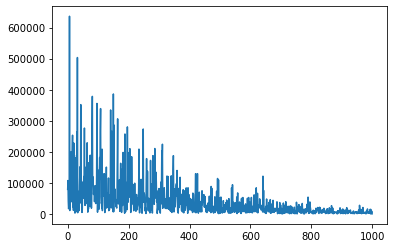

In [6]:
plt.plot(history.history['loss'])

In [7]:
for weights in model.get_weights():
    print('Weight/bias:', weights)

Weight/bias: [[1.9437819]
 [1.3402412]]
Weight/bias: [[2.500281 ]
 [2.0842643]]
Weight/bias: [0.6693698]
Weight/bias: [1.5750488]


In [8]:
y_predict = np.zeros((N_SAMPLES, N_DATA))
for i in trange(N_SAMPLES):
    y_predict[i] = model.predict(Xy.batch(N_DATA)).flatten()

100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


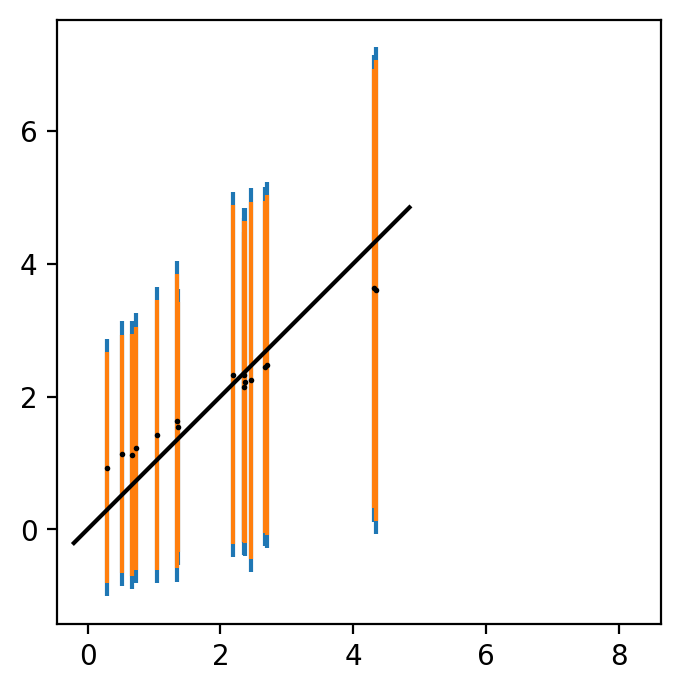

In [9]:
plt.figure(dpi=200)
plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0) + 2*LIKELIHOOD_STDDEV, 
             linestyle='None', marker=None)

plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0), 
             linestyle='None', marker='o', mec='k', ms=1)

plt.plot([y.min()-0.5, y.max()+0.5], [y.min()-0.5, y.max()+0.5], 'k')

plt.axis('square')


plt.show()

In [10]:
Xb = np.concatenate([X, np.ones((N_DATA, 1))], axis=1)
# Xb = X
Sigma_0 = PRIOR_STDDEV**2 * np.eye(Xb.shape[1])
Sigma_e = LIKELIHOOD_STDDEV**2 * np.eye(N_DATA)
Sigma_k = np.linalg.inv(np.linalg.inv(Sigma_0) + Xb.T @ Xb/LIKELIHOOD_STDDEV**2)
Mu_k = Sigma_k @ (Xb.T @ y/LIKELIHOOD_STDDEV**2)

In [11]:
Mu_k

array([[ 2.9611044 ],
       [ 2.06274995],
       [-0.03045692]])

In [12]:
print(model.get_weights()[0])
print(model.get_weights()[2])

[[1.9437819]
 [1.3402412]]
[0.6693698]


In [13]:
Sigma_k

array([[ 1.67198019e-02, -8.95822761e-03,  6.29143709e-05],
       [-8.95822761e-03,  1.24619759e-02, -4.28791072e-03],
       [ 6.29143709e-05, -4.28791072e-03,  2.98722145e-03]])

In [14]:
U, s, V = np.linalg.svd(Sigma_k)
U @ np.diag(s**0.5) @ V
# np.linalg.cholesky(Sigma_k)


array([[ 0.12209459, -0.0418369 , -0.0078985 ],
       [-0.0418369 ,  0.09819937, -0.03268844],
       [-0.0078985 , -0.03268844,  0.04308481]])

In [15]:
print(np.log(np.exp(model.get_weights()[1]) + 1))
print(np.log(np.exp(model.get_weights()[3]) + 1))

[[2.5791495]
 [2.2015126]]
[1.7631847]
